## Homework Day 3 Solutions

In [2]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from scipy.stats import norm

### Exercise 1

In [3]:
S = 20
p = 0.5
c = 0.1

In [4]:
@numba.jit
def post_order_stock(s, x):
    if x > s:
        return x
    else:
        return S

In [5]:
@numba.jit(nopython=True)
def sim_profit_path(s, initial_x=50.0, sim_length=10_000_000):
    
    np.random.seed(1234)
    dvals = np.random.geometric(p, size=sim_length-1) - 1
    profits = np.empty(sim_length, dtype=np.float32)
    x = initial_x

    for t, d in enumerate(dvals):
        stock = post_order_stock(s, x)
        profits[t] = np.minimum(stock, d) - c * (x <= s)
        
        if x <= s:
            x = max(S - d, 0)
        else:
            x = max(x - d, 0)
            
    return profits

In [6]:
@numba.jit(nopython=True)
def compute_profits():
    profit_vals = np.empty(S, dtype=np.float64)
    for s in range(S):
        profit_path = sim_profit_path(s)
        profit_vals[s] = profit_path.mean()
        
    return profit_vals

In [7]:
@numba.jit(nopython=True, parallel=True)
def compute_profits_parallel():
    profit_vals = np.empty(S, dtype=np.float64)
    for s in numba.prange(S):
        profit_path = sim_profit_path(s)
        profit_vals[s] = profit_path.mean()
        
    return profit_vals

In [8]:
%%time
profit_vals = compute_profits()

CPU times: user 7.45 s, sys: 621 ms, total: 8.08 s
Wall time: 8.13 s


In [9]:
%%time
profit_vals = compute_profits_parallel()

CPU times: user 9.86 s, sys: 828 ms, total: 10.7 s
Wall time: 3.3 s


In [10]:

profit_vals = compute_profits_parallel()

Here's long run average profits:

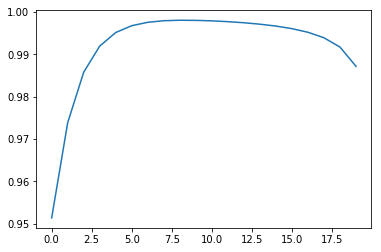

In [11]:
fig, ax = plt.subplots()
ax.plot(range(S), profit_vals)
plt.show()

### Exercise 2

Here's the code we wrote for estimating KDEs:

In [13]:
K = norm.pdf

class KDE:
    
    def __init__(self, x_data, h=None):

        if h is None:
            σ = x_data.std()
            n = len(x_data)
            h = 1.06 * σ * n**(-1/5)
        self.h = h
        self.x_data = x_data

    def f(self, x):
        if np.isscalar(x):
            return K((x - self.x_data) / self.h).mean() * (1/self.h)
        else:
            y = np.empty_like(x)
            for i, x_val in enumerate(x):
                y[i] = K((x_val - self.x_data) / self.h).mean() * (1/self.h)
            return y


def plot_kde(ϕ, x_min=-0.2, x_max=1.2):
    x_data = ϕ.rvs(n)
    kde = KDE(x_data)
    
    x_grid = np.linspace(-0.1, 1.1, 100)
    fig, ax = plt.subplots()
    ax.plot(x_grid, kde.f(x_grid))
    ax.plot(x_grid, ϕ.pdf(x_grid))
    plt.show()


Here's a solution to the exercise:

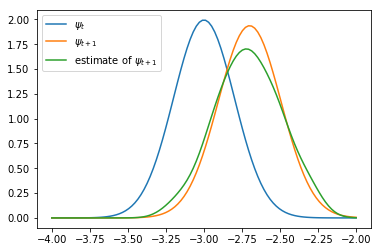

In [14]:
ρ = 0.9
b = 0.0
σ = 0.1
μ = -3
s = 0.2

μ_next = ρ * μ + b
s_next = np.sqrt(ρ**2 * s**2 + σ**2)

ψ = lambda x: K((x - μ) / s)
ψ_next = lambda x: K((x - μ_next) / s_next)

ψ = norm(μ, s)
ψ_next = norm(μ_next, s_next)

n = 100
x_draws = ψ.rvs(n)
x_draws_next = ρ * x_draws + b + σ * np.random.randn(n)
kde = KDE(x_draws_next)

x_grid = np.linspace(μ - 1, μ + 1, 100)
fig, ax = plt.subplots()

ax.plot(x_grid, ψ.pdf(x_grid), label="$\psi_t$")
ax.plot(x_grid, ψ_next.pdf(x_grid), label="$\psi_{t+1}$")
ax.plot(x_grid, kde.f(x_grid), label="estimate of $\psi_{t+1}$")

ax.legend()
plt.show()